In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using MKLSparse
using LinearAlgebra
using Flux, DiffEqFlux
using Optim
using Plots
using DifferentialEquations: Tsit5, DP5
using Random
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)

false

$$H = \frac{\Omega(t)}{2}\left[e^{i\phi(t)} (\sigma_+^1 + \sigma_+^2) +  e^{-i\phi(t)} (\sigma_-^1+\sigma_-^2)\right] - \Delta(t) (n_1 + n_2) + V n_1n_2$$

In [2]:
V = 2π*10.0 # MHz

62.83185307179586

In [3]:
bs = NLevelBasis(3)
bsys = bs⊗bs

id = identityoperator(bs)

sp1 = transition(bs, 3, 2)⊗id
sm1 = transition(bs, 2, 3)⊗id

sp2 = id⊗transition(bs, 3, 2)
sm2 = id⊗transition(bs, 2, 3)

n1 = transition(bs, 3, 3)⊗id
n2 = id⊗transition(bs, 3, 3);

In [4]:
H = Hamiltonian(V*(n1*n2))
H += (n1 + n2)
H += (sp1 + sp2 + sm1 + sm2)
H += 1.0im*(sp1 + sp2 - sm1 - sm2);

In [5]:
states= [nlevelstate(bs, 1)⊗nlevelstate(bs, 1),
         nlevelstate(bs, 1)⊗nlevelstate(bs, 2),
         nlevelstate(bs, 2)⊗nlevelstate(bs, 1),
         nlevelstate(bs, 2)⊗nlevelstate(bs, 2)]

trans = UnitaryTransform(states, [[1.0 0 0 0 ];[0 1.0 0 0 ];[0 0 1.0 0 ]; [0 0 0 -1.0]]);

In [6]:
n_neurons = 4
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, 3))
θ = initial_params(ann)     
n_params = length(θ);
Random.seed!(3)
θ = 2.0*rand(n_params).-1.0;

In [7]:
t0, t1 = 0.0, 1.0
sigmoid(x)= @. 2π*7 / (1 + exp(-x))
coeffs(p) = t->let vals = ann([t], p)
                [-vals[1], sigmoid(vals[2])*cos(vals[3]), sigmoid(vals[2])*sin(vals[3])]
               end    
dr = ParametricDrive(Vector{Float64}(θ), coeffs, (t0, t1))
cost = CostFunction((x, y) -> x'*y,
                     p->2e-2*(sigmoid(ann([t0], p)[2])^2 + sigmoid(ann([t1], p)[2])^2))

prob = QOCProblem(H, dr, trans, cost);

In [8]:
sol = QuantumOptimalControl.optimize(prob, ADAM(0.008), alg=Tsit5(), 
                                     n_iter=2000, abstol=1e-6, reltol=1e-6)

Progress: 100%|█████████████████████████████████████████| Time: 0:13:47
  cost:  0.9981769720945406


Solution{Float64}([0.8400765737057596, 2.326560388167186, -0.5066669608627995, 1.3279794718994404, 0.586286381587044, -0.00947443251475124, -0.05941918330824658, -0.8357759347813548, -0.205519888534343, -0.7866092471664837  …  0.5845044566908776, -2.874874308004302, -0.6554271832666689, 2.0128445657243086, -1.365934692229344, -1.411928359072274, -0.03514932366826655, -0.5211438023008195, -0.6130441755731763, -0.8939622747325265], [-0.18737682639481748, 0.060267586656537225, 0.4509134929898442, 0.8250246673403733, 0.8183874074550208, 0.37922741139417193, -0.06620719178693679, -0.1775586608067304, 0.02623222115057386, 0.293755770579787  …  0.9980949908633603, 0.9981061255837415, 0.9981134294147211, 0.9981242459492441, 0.9981317226574332, 0.9981420675645101, 0.9981498055069686, 0.9981596340033962, 0.9981676348016586, 0.9981769720945406])

In [9]:
cost.constraints = p->(sigmoid(ann([t0], p)[2])^2 + sigmoid(ann([t1], p)[2])^2)
sol = QuantumOptimalControl.optimize(prob, ADAM(0.008), alg=Tsit5(), 
                                     n_iter=500, abstol=1e-6, reltol=1e-6)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:28
  cost:  0.993938574656229


Solution{Float64}([0.8136709722881551, 2.490781476981623, -0.5082957313646437, 1.340468859185373, 0.5961672695110808, -0.05123774980381227, -0.0697708744940775, -0.8640959353810856, -0.21667415443027147, -0.7849854746067861  …  0.4471479638853925, -3.285488810208833, -1.1258535758586625, 2.442125835559138, -0.8659911167608777, -2.095933433466674, -0.5609849277202242, -0.9259877020136718, -0.8271473468516303, -0.8939622736924207], [0.9981851894234226, 0.06979016494738394, 0.7494414810366925, 0.7666681845516602, 0.7492084669686236, 0.9739078128829837, 0.8219762913459356, 0.6871084049604194, 0.7788836438152558, 0.9299181457574776  …  0.9937556710360862, 0.9937765532476767, 0.9937972931454998, 0.9938178917440141, 0.9938383501284935, 0.9938586692809264, 0.99387885031918, 0.9938988941655963, 0.9939188020093641, 0.993938574656229])

In [10]:
Ω(t) = sigmoid(ann([t], prob.drive.params)[2])
Δ(t) = -ann([t], prob.drive.params)[1]
ϕ(t) = ann([t], prob.drive.params)[3]

ϕ (generic function with 1 method)

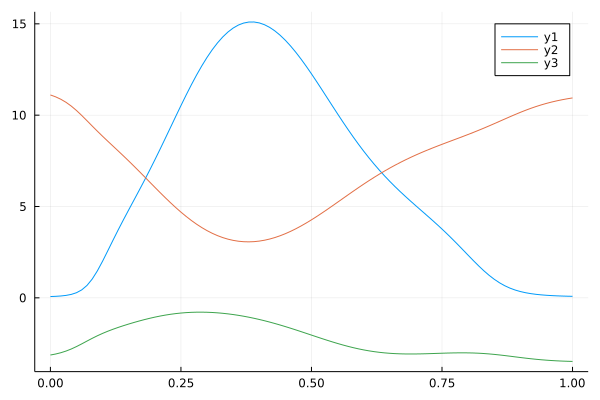

In [11]:
ts = t0:t1/100:t1
f = plot(ts, Ω.(ts))
plot!(f, ts, Δ.(ts))
plot!(f, ts, ϕ.(ts))